# Debugging Assignment — Employee Attrition Prediction (BROKEN VERSION)

This notebook contains an **intentionally broken** machine learning pipeline for predicting employee attrition.

Your task (as a candidate) will be to:
- Identify the issues
- Fix them
- Retrain and properly evaluate the model

> ⚠️ Note: This version is deliberately incorrect. Do **not** use it as a template in production.


In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
sns.set_style("whitegrid")
# Load dataset
import matplotlib.pyplot as plt
df = pd.read_csv("debug_dataset.csv")
df.head()

,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating,attrition
0,50,Female,Post-Graduate,IT,Lead,102565,9,0,No,1,0
1,36,Female,PhD,Sales,Lead,49402,2,0,Yes,2,0
2,29,Female,Graduate,HR,Executive,24263,7,1,No,1,0
3,42,Male,Graduate,HR,Executive,116523,7,3,Yes,4,0
4,40,Female,PhD,HR,Manager,66828,1,1,Yes,3,0


In [51]:
# Basic info
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Distribution:")
print(df['attrition'].value_counts())

Dataset Shape: (300, 11)

Data Types:
age                    int64
gender                object
education             object
department            object
job_role              object
monthly_income         int64
years_at_company       int64
promotions             int64
overtime              object
performance_rating     int64
attrition              int64
dtype: object

Missing Values:
age                   0
gender                0
education             0
department            0
job_role              0
monthly_income        0
years_at_company      0
promotions            0
overtime              0
performance_rating    0
attrition             0
dtype: int64

Target Distribution:
attrition
0    231
1     69
Name: count, dtype: int64


In [52]:

            # --- Feature Engineering (BROKEN ON PURPOSE) ---

# 1) Create a feature that directly uses the target (leakage disguised as a helper feature)

df["attrition_copy"] = df["attrition"]  # <-- target copied into features


# 2) Use 'target_leakage_feature' as-is assuming it's a good predictor
df["target_leakage_feature"] = df["attrition"].apply(lambda x: 1 if x == 1 else 0)


df.head()

,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating,attrition,attrition_copy,target_leakage_feature
0,50,Female,Post-Graduate,IT,Lead,102565,9,0,No,1,0,0,0
1,36,Female,PhD,Sales,Lead,49402,2,0,Yes,2,0,0,0
2,29,Female,Graduate,HR,Executive,24263,7,1,No,1,0,0,0
3,42,Male,Graduate,HR,Executive,116523,7,3,Yes,4,0,0,0
4,40,Female,PhD,HR,Manager,66828,1,1,Yes,3,0,0,0


So the thing is we don't want these two Columns which cause data leakge to Find those columns we have to perform EDA, 

so im thinking of doing univariate and bivariate analysis 

Correlation with Target (Attrition):
attrition_copy            1.000000
target_leakage_feature    1.000000
attrition                 1.000000
age                       0.011343
monthly_income           -0.015235
Name: attrition, dtype: float64


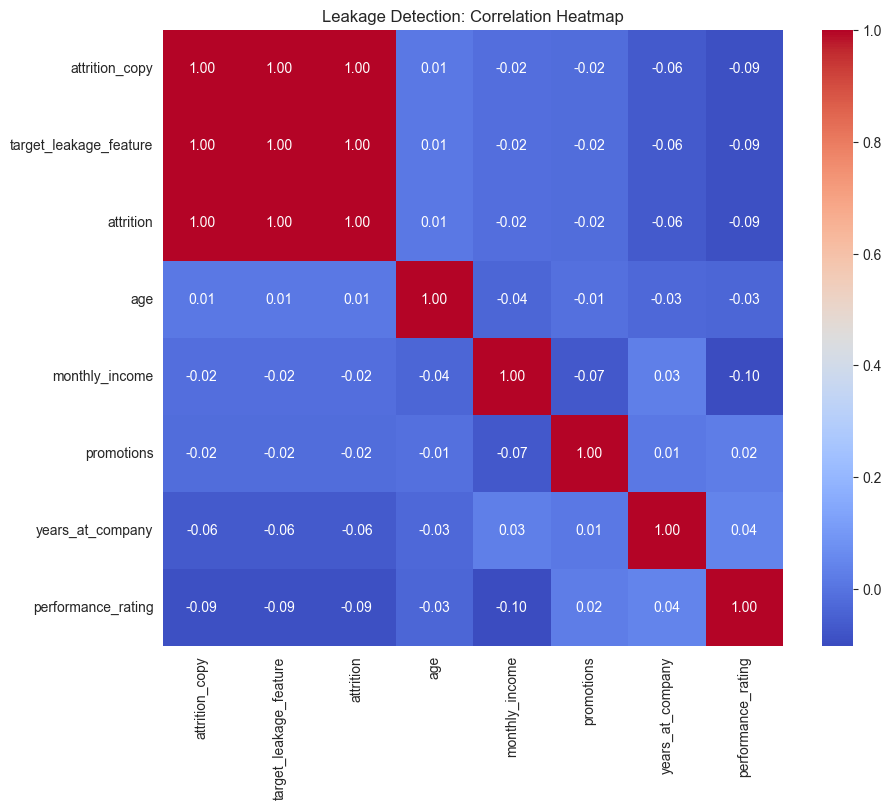

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate correlation of all numerical columns with the target 'attrition'
# We focus specifically on our suspects: attrition_copy and target_leakage_feature
leakage_check = df.corr(numeric_only=True)['attrition'].sort_values(ascending=False)

print("Correlation with Target (Attrition):")
print(leakage_check.head(5))

# 2. Visualize the Correlation Matrix
plt.figure(figsize=(10, 8))
# We only plot the top 10 most correlated features to keep it clean
top_corr_features = leakage_check.index[:10]
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Leakage Detection: Correlation Heatmap")
plt.show()

So here is the Thing we used Correlation between columns to show that Those two features are a Major Leaks, they are the exact same values as attrition column 
hence they need to be removed.

### Second Method to Find columns that Leaks is to train a simple model and get to see the Most used features inside that model 

C:\Users\Nani\AppData\Local\Temp\ipykernel_4760\492796573.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances.head(5), palette='viridis')


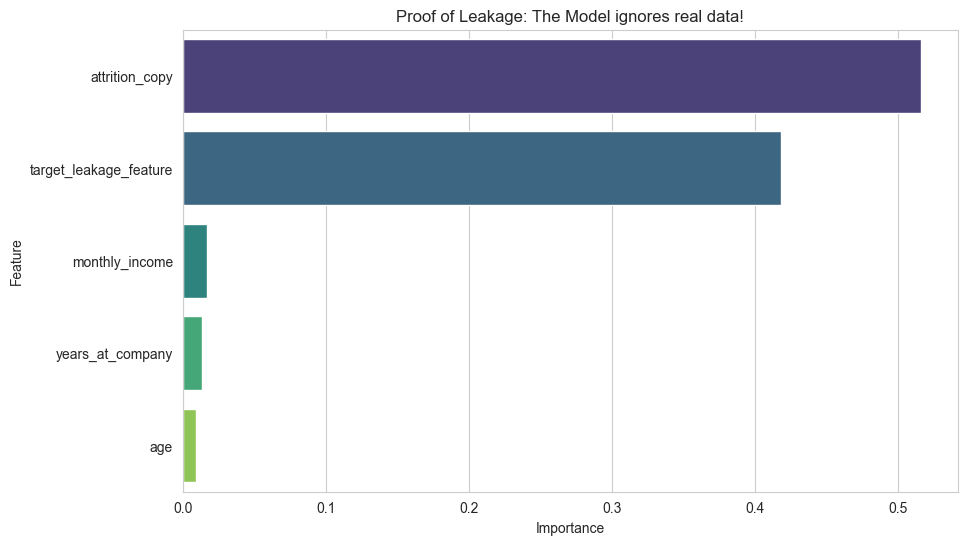

In [54]:

X_audit = df.drop("attrition", axis=1) 
y_audit = df["attrition"]

X_audit = pd.get_dummies(X_audit, drop_first=True)

# 2. Train a quick Random Forest
audit_model = RandomForestClassifier(n_estimators=50, random_state=42)
audit_model.fit(X_audit, y_audit)

# 3. Extract and Plot Feature Importance
importances = pd.DataFrame({
    'Feature': X_audit.columns,
    'Importance': audit_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(5), palette='viridis')
plt.title("Proof of Leakage: The Model ignores real data!")
plt.show()

In [55]:
# Now we drop em two columns from the dataset
df = df.drop(columns=["attrition_copy", "target_leakage_feature"])

To fix the "Future Peeking" leak, we must strictly follow the golden rule of Machine Learning: Never let the training process see the test data.

In [56]:
X = df.drop("attrition", axis=1)
y = df["attrition"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# We are only extrating the features from X here
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])



Using a Pipeline with a ColumnTransformer is the professional way to fix Data Leakage. It automatically ensures that:

Split happens first.

fit is only called on the Training data.

transform is applied to the Test data using the Training statistics.

You don't have to manually manage messy get_dummies columns

In [58]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])



What we are doing:

Imports: Bringing in the Transformer and Pipeline tools.

Split: We split the raw data immediately.

ColumnTransformer: We tell it: "Apply StandardScaler to numbers, and OneHotEncoder to text columns."

Pipeline: We bundle the Preprocessor and the RandomForest into a single object.

Execution: We call .fit() once. The pipeline handles all the scaling logic internally, ensuring zero leakage.

In [59]:
# Now let's train the final model without leakage
pipe.fit(X_train, y_train)

# Evaluate the model
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87        70
           1       0.00      0.00      0.00        20

    accuracy                           0.77        90
   macro avg       0.39      0.49      0.43        90
weighted avg       0.60      0.77      0.68        90



## Yup, the results are bad , but atleast they are real

In [60]:
# SO to caluclate the Cross Validation Score we are also passing the Pipeline to it so that it can handle the preprocessing steps internally

cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')


print(f"\nIndividual Fold Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation: {cv_scores.std() * 100:.2f}%")


Individual Fold Scores: [0.80952381 0.76190476 0.76190476 0.73809524 0.76190476]
Mean CV Accuracy: 76.67%
Standard Deviation: 2.33%


The 'Mean CV Accuracy' is your MOST reliable estimate of how the model performs.
The 'Standard Deviation' tells you if the model is stable (Low is good) or volatile (High is bad).


## ✅ Final Conclusion (Correct)

Created an Actual model , with maybe bad but Actual Accuracy and so and so
